# Proyek Klasifikasi Gambar: Rice Image Dataset
- **Nama:** Ferdian Sakti
- **Email:** ferdian@smkdb1jombang.sch.id
- **ID Dicoding:** ferdian_sakti

## Import Semua Packages/Library yang Digunakan

In [56]:
# Instalasi library yang diperlukan
!pip install tensorflow tensorflowjs kaggle -q
!pip install tensorflowjs -q

import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflowjs as tfjs
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from google.colab import files
from sklearn.metrics import confusion_matrix, classification_report

## Data Preparation

In [18]:
# Setup Kaggle API jika diperlukan
os.makedirs('/root/.kaggle', exist_ok=True)
!cp /content/sample_data/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [19]:
# Download dataset
!kaggle datasets download -d muratkokludataset/rice-image-dataset -q

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0


In [22]:
# Ekstrak dataset
!unzip -q rice-image-dataset.zip -d dataset

replace dataset/Rice_Image_Dataset/Arborio/Arborio (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace dataset/Rice_Image_Dataset/Arborio/Arborio (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [21]:
# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/dataset/Rice_Image_Dataset',
    validation_split=0.2,
    subset="training",
    seed=42,
    batch_size=32
)

Found 75000 files belonging to 5 classes.
Using 60000 files for training.


In [23]:
# Daftar kelas
classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [24]:
# Path dataset setelah diekstrak
base_dir = '/content/dataset/Rice_Image_Dataset'

In [25]:
# Cek isi direktori untuk memastikan struktur
!ls -R /content/dataset | head -20

/content/dataset:
Rice_Image_Dataset

/content/dataset/Rice_Image_Dataset:
Arborio
Basmati
Ipsala
Jasmine
Karacadag
Rice_Citation_Request.txt

/content/dataset/Rice_Image_Dataset/Arborio:
Arborio (10000).jpg
Arborio (10001).jpg
Arborio (10002).jpg
Arborio (10003).jpg
Arborio (10004).jpg
Arborio (10005).jpg
Arborio (10006).jpg
Arborio (10007).jpg


In [26]:
# Baca semua file gambar
all_image_paths = []
all_labels = []

for klass in classes:
    class_dir = os.path.join(base_dir, klass)
    if not os.path.isdir(class_dir):
        print(f"Folder '{klass}' tidak ditemukan di '{base_dir}'")
        continue
    image_files = glob.glob(os.path.join(class_dir, "*.jpg"))  # Mencari .jpg
    if len(image_files) == 0:
        print(f"Tidak ada file .jpg ditemukan di {class_dir}")
    all_image_paths.extend(image_files)
    all_labels.extend([klass] * len(image_files))

In [27]:
# Ambil nama kelas dari dataset
class_names = train_ds.class_names
print("Kelas ditemukan:", class_names)

Kelas ditemukan: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [28]:
# Simpan ke file label.txt
with open('label.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

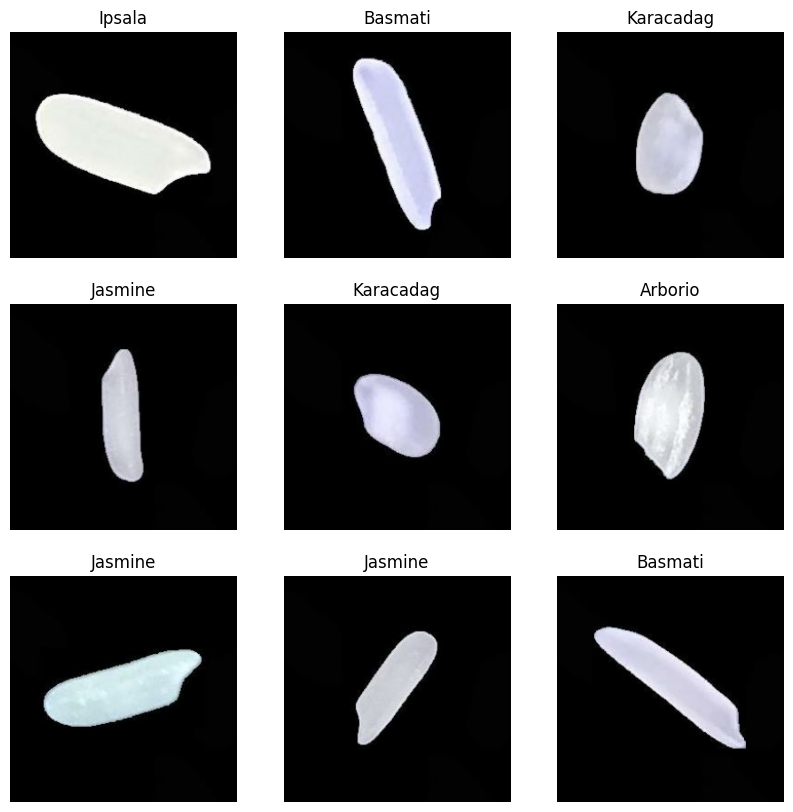

In [29]:
# Tampilkan sampel gambar
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.show()

In [30]:
# Buat DataFrame
df = pd.DataFrame({
    'filename': all_image_paths,
    'class': all_labels
})

print(f"\nTotal gambar ditemukan: {len(df)}")


Total gambar ditemukan: 75000


### Data Preprocessing

#### Split Dataset

In [31]:
# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['class'], random_state=42)

Pembagian dataset dilakukan dalam dua tahap untuk membagi data menjadi training set, validation set, dan test set dengan distribusi kelas yang proporsional.

Pada langkah pertama, dataset utama dibagi menjadi 80% untuk pelatihan dan 20% untuk testing (test_size=0.2). Penggunaan parameter stratify=df['class'] memastikan bahwa distribusi kelas di test set tetap seimbang seperti pada dataset asli.

Selanjutnya, dari 80% data pelatihan tersebut, dilakukan pembagian ulang dengan test_size=0.2, sehingga 20% dari 80% (atau 16% dari total data ) dialokasikan sebagai validation set, dan sisanya (64% dari total data ) digunakan sebagai training set.

Dengan demikian, hasil akhir pembagian dataset adalah:
* 64% untuk training set
* 16% untuk validation set
* 20% untuk test set

In [32]:
# Augmentasi data
img_size = (150, 150)
batch_size = 32

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen_val_test = ImageDataGenerator(rescale=1./255)

In [33]:
# Generator
train_gen = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = datagen_val_test.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen_val_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 48000 validated image filenames belonging to 5 classes.
Found 12000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.


## Modelling

In [34]:
# Callback untuk menghentikan pelatihan saat validasi tidak membaik
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [35]:
# Callback untuk menyimpan model terbaik berdasarkan val_accuracy
model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [36]:
# Model CNN sederhana (menerapkan Model Sequential, Conv2D, Pooling Layer)
model = Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training dengan callbacks
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, model_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7273 - loss: 0.6492
Epoch 1: val_accuracy improved from -inf to 0.74825, saving model to best_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 246s 160ms/step - accuracy: 0.7274 - loss: 0.6490 - val_accuracy: 0.7483 - val_loss: 0.7025
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9175 - loss: 0.2241
Epoch 2: val_accuracy improved from 0.74825 to 0.97167, saving model to best_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 239s 159ms/step - accuracy: 0.9176 - loss: 0.2241 - val_accuracy: 0.9717 - val_loss: 0.0836
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9535 - loss: 0.1322
Epoch 3: val_accuracy improved from 0.97167 to 0.99083, saving model to best_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 239s 160ms/step - accuracy: 0.9535 - loss: 0.1322 - val_accuracy: 0.9908 - val_loss: 0.0292
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9630 - loss: 0.1080
Epoch 4: val_accuracy did not improve from 0.99083
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 238s 159ms/step - accuracy: 0.9630 - loss: 0.1080 - val_accuracy: 0.9872 - val_loss: 0.0399
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9708 - loss: 0.0883
Epoch 5: val_accuracy did not improve from 0.99083
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 242s 161ms/step - accuracy: 0.9708 - loss: 0.0883 - val_accuracy: 0.9893 - val_loss: 0.0340
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9762 - loss: 0.0724
Epoch 6: val_accuracy did not improve from 0.99083
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 238s 159ms/step - accuracy: 0.9762 - loss: 0.0724 - val_accuracy: 0.9550 - val_loss: 0.1235
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9734 - loss: 0.

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 242s 161ms/step - accuracy: 0.9734 - loss: 0.0806 - val_accuracy: 0.9924 - val_loss: 0.0238
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9750 - loss: 0.0799
Epoch 8: val_accuracy did not improve from 0.99242
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 239s 159ms/step - accuracy: 0.9750 - loss: 0.0799 - val_accuracy: 0.9918 - val_loss: 0.0235
Epoch 9/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9807 - loss: 0.0623
Epoch 9: val_accuracy did not improve from 0.99242
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 238s 159ms/step - accuracy: 0.9807 - loss: 0.0623 - val_accuracy: 0.9662 - val_loss: 0.1335
Epoch 10/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9805 - loss: 0.0598
Epoch 10: val_accuracy did not improve from 0.99242
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 241s 160ms/step - accuracy: 0.9805 - loss: 0.0598 - val_accuracy: 0.9907 - val_loss: 0.0269
Epoch 11/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9840 - loss:

## Evaluasi dan Visualisasi

In [37]:
# Evaluasi model
# Ambil nilai-nilai dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)  # Epoch dimulai dari 1

In [38]:
# 1. Nilai dari epoch terakhir
last_epoch = len(acc)
last_train_acc = acc[-1]
last_val_acc = val_acc[-1]
last_train_loss = loss[-1]
last_val_loss = val_loss[-1]

In [39]:
# 2. Nilai validation accuracy terbaik beserta epoch-nya
best_val_acc = max(val_acc)
best_epoch = val_acc.index(best_val_acc) + 1  # +1 karena epoch dimulai dari 1
best_train_acc = acc[best_epoch-1]
best_train_loss = loss[best_epoch-1]
best_val_loss = val_loss[best_epoch-1]

In [40]:
# Cetak hasil dari epoch terakhir
print("\n=== Hasil Epoch Terakhir ===")
print(f"Epoch: {last_epoch}")
print(f"Training Accuracy: {last_train_acc*100:.2f}%")
print(f"Validation Accuracy: {last_val_acc*100:.2f}%")
print(f"Training Loss: {last_train_loss:.4f}")
print(f"Validation Loss: {last_val_loss:.4f}")


=== Hasil Epoch Terakhir ===
Epoch: 13
Training Accuracy: 98.51%
Validation Accuracy: 98.16%
Training Loss: 0.0472
Validation Loss: 0.0663


In [41]:
# Cetak hasil terbaik
print("\n=== Hasil Terbaik ===")
print(f"Epoch Terbaik: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")
print(f"Training Accuracy pada Epoch Terbaik: {best_train_acc*100:.2f}%")
print(f"Training Loss pada Epoch Terbaik: {best_train_loss:.4f}")
print(f"Validation Loss pada Epoch Terbaik: {best_val_loss:.4f}")


=== Hasil Terbaik ===
Epoch Terbaik: 7
Best Validation Accuracy: 99.24%
Training Accuracy pada Epoch Terbaik: 97.53%
Training Loss pada Epoch Terbaik: 0.0750
Validation Loss pada Epoch Terbaik: 0.0238


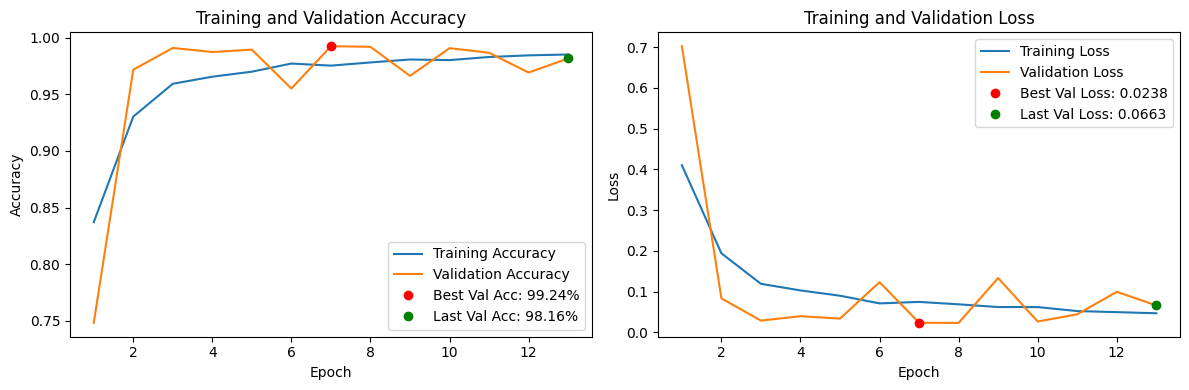

In [42]:
# Plot hasil training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(best_epoch, best_val_acc, 'ro', label=f'Best Val Acc: {best_val_acc*100:.2f}%')
plt.plot(last_epoch, last_val_acc, 'go', label=f'Last Val Acc: {last_val_acc*100:.2f}%')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.plot(best_epoch, best_val_loss, 'ro', label=f'Best Val Loss: {best_val_loss:.4f}')
plt.plot(last_epoch, last_val_loss, 'go', label=f'Last Val Loss: {last_val_loss:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step


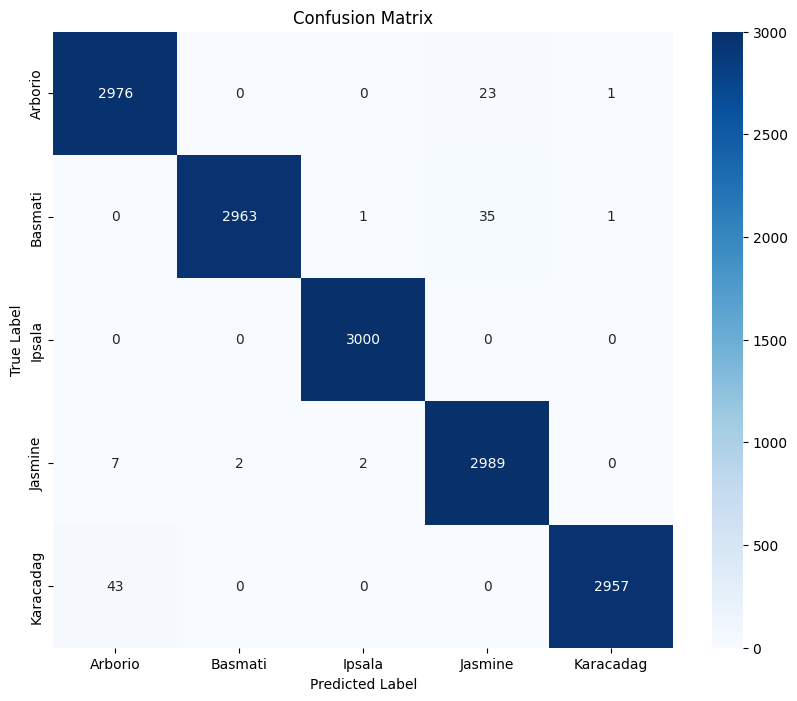

In [43]:
# Prediksi dan label
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [44]:
# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

     Arborio       0.98      0.99      0.99      3000
     Basmati       1.00      0.99      0.99      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       0.98      1.00      0.99      3000
   Karacadag       1.00      0.99      0.99      3000

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000



## Konversi Model

In [45]:
# Load best model from checkpoint
best_model = tf.keras.models.load_model('best_model.h5')

In [46]:
# 1. SavedModel Format
saved_model_dir = 'saved_model'
tf.saved_model.save(best_model, saved_model_dir)

In [47]:
# 2. TFLite Format
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpquth42it'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  134225449717008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134225119943504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134225119943696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134225119944656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134225119940432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134225119940816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134225119944464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134225119940624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134225119942736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134225119946000: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [48]:
# 3. TFJS Format
tfjs_dir = 'tfjs_model'
tfjs.converters.save_keras_model(best_model, tfjs_dir)

failed to lookup keras version from the file,
    this is likely a weight only file


In [49]:
# 4. Download semua file termasuk label
!zip -r saved_model.zip saved_model
!zip -r tfjs_model.zip tfjs_model
files.download('label.txt')  # Pastikan ini dijalankan
files.download('model.tflite')
files.download('saved_model.zip')
files.download('tfjs_model.zip')

  adding: saved_model/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 85%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 53%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard2of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard3of5.bin (deflated 6%)
  adding: tfjs_model/model.json (deflated 85%)
  adding: tfjs_model/group1-shard5of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard1of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard4of5.bin (deflated 6%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

In [66]:
# Upload gambar dari lokal
uploaded = files.upload()

Saving jasmine-rice-brown-mixed-on-260nw-1060154090.jpg to jasmine-rice-brown-mixed-on-260nw-1060154090.jpg


Gambar berhasil diupload: jasmine-rice-brown-mixed-on-260nw-1060154090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


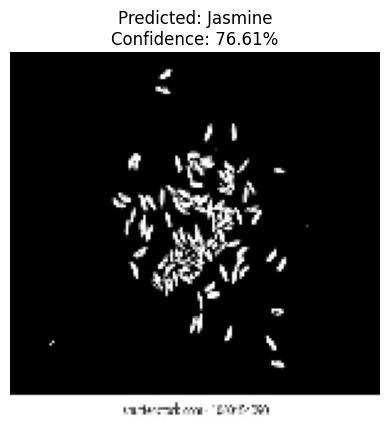

Hasil Prediksi: Jasmine
Tingkat Akurasi: 76.61%


In [67]:
# Ambil path file yang diupload
for filename in uploaded.keys():
    img_path = filename
    print(f"Gambar berhasil diupload: {img_path}")

# Fungsi untuk prediksi satu gambar
def predict_image(img_path, model, class_names, target_size=(150, 150)):
    # Load dan preprocess gambar
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100  # Konversi ke persentase

    # Tampilkan hasil
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

# Daftar nama kelas
class_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

# Prediksi
predicted, confidence = predict_image(img_path, model, class_names)
print(f"Hasil Prediksi: {predicted}")
print(f"Tingkat Akurasi: {confidence:.2f}%")